## TensorFlow - LSTM
In this notebook we will implement LSTM layer from scratch. Then we will use **LSTM** layer to do time series prediction.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow.keras.layers import Input, LSTM, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD, Adam

%matplotlib inline

In [2]:
# Lets define these variables
# N = number of samples
# T = sequence length
# D = number of input features
# M = number of hidden units
# K = number of output units

np.random.seed(42)
N = 1
T = 1
D = 3
K = 2
X = np.random.randn(N, T, D)

In [3]:
# Make an LSTM
M = 5 # number of hidden units
i = Input(shape=(T, D))
x = LSTM(M)(i)
x = Dense(K)(x)

model = Model(i, x)

In [4]:
# Get the output 
Yhat = model.predict(X)
print(Yhat)

[[ 0.06722622 -0.09127428]]


In [5]:
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 1, 3)]            0         
_________________________________________________________________
lstm (LSTM)                  (None, 5)                 180       
_________________________________________________________________
dense (Dense)                (None, 2)                 12        
Total params: 192
Trainable params: 192
Non-trainable params: 0
_________________________________________________________________


In [6]:
#Check the shapes of the layers
a, b, c = model.layers[1].get_weights()
print(a.shape, b.shape, c.shape)

(3, 20) (5, 20) (20,)


In [7]:
Wx, Wh, bh = model.layers[1].get_weights()
Wo, bo = model.layers[2].get_weights()

In [8]:
def sigmoid(x):
    return 1 / (1 + np.exp(-x))

#Initialize the hidden state
h_last = np.zeros(M)
c_last = np.zeros(M)
#First sample
x = X[0] 
Yhats = []

for t in range(T):
    f = sigmoid(x[t].dot(Wx[:,5:10]) + h_last.dot(Wh[:,5:10]) + bh[5:10]) 
    i = sigmoid(x[t].dot(Wx[:,0:5]) + h_last.dot(Wh[:,0:5]) + bh[0:5]) 
    o = sigmoid(x[t].dot(Wx[:,15:20]) + h_last.dot(Wh[:,15:20]) + bh[15:20]) 
    c = f * c_last + i * np.tanh(x[t].dot(Wx[:,10:15]) + h_last.dot(Wh[:,10:15]) + bh[10:15])
    h = o * np.tanh(c)
    y = h.dot(Wo) + bo 
    Yhats.append(y)
  
    h_last = h
    c_last = c

# print the final output
print(Yhats[-1])

[ 0.0672262  -0.09127427]


Our implementation of **LSTM** layer matches TensorFlow

In [9]:
#Lets make synthetic data
# make the original data
series = np.sin(np.linspace(0,10*np.pi,1000)**2)

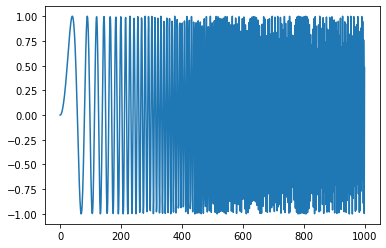

In [10]:
plt.plot(series)

In [11]:
#build the dataset
#we will use 200 last time steps to predict next step
T = 200
D = 1
X = []
Y = []
for t in range(len(series) - T):
    x = series[t:t+T]
    X.append(x)
    y = series[t+T]
    Y.append(y)

X = np.array(X).reshape(-1, T) # make it N x T
Y = np.array(Y)
N = len(X)
print("X.shape", X.shape, "Y.shape", Y.shape)

X.shape (800, 200) Y.shape (800,)


In [12]:
#LSTM Model
X = X.reshape(-1, T, 1) # make it N x T x D

i = Input(shape=(T, D))
x = LSTM(10)(i)
x = Dense(1)(x)
model = Model(i, x)
model.compile(
  loss='mse',
  optimizer=Adam(lr=0.05),
)

# train the RNN
r = model.fit(
  X[:600], Y[:600],
  batch_size=32,
  epochs=200,
  validation_data=(X[600:], Y[600:]),
)

Epoch 1/200
19/19 [==============================] - 1s 78ms/step - loss: 0.4299 - val_loss: 0.7658
Epoch 2/200
19/19 [==============================] - 1s 43ms/step - loss: 0.1158 - val_loss: 0.4389
Epoch 3/200
19/19 [==============================] - 1s 45ms/step - loss: 0.0424 - val_loss: 0.2070
Epoch 4/200
19/19 [==============================] - 1s 48ms/step - loss: 0.0112 - val_loss: 0.1057
Epoch 5/200
19/19 [==============================] - 1s 51ms/step - loss: 0.0047 - val_loss: 0.0741
Epoch 6/200
19/19 [==============================] - 1s 61ms/step - loss: 0.0030 - val_loss: 0.0647
Epoch 7/200
19/19 [==============================] - 1s 47ms/step - loss: 0.0022 - val_loss: 0.0591
Epoch 8/200
19/19 [==============================] - 1s 49ms/step - loss: 0.0017 - val_loss: 0.0475
Epoch 9/200
19/19 [==============================] - 1s 48ms/step - loss: 0.0015 - val_loss: 0.0427
Epoch 10/200
19/19 [==============================] - 1s 49ms/step - loss: 0.0012 - val_loss: 0.0416

19/19 [==============================] - 1s 57ms/step - loss: 1.7298e-04 - val_loss: 0.0084
Epoch 80/200
19/19 [==============================] - 1s 60ms/step - loss: 1.1214e-04 - val_loss: 0.0058
Epoch 81/200
19/19 [==============================] - 1s 59ms/step - loss: 8.8428e-05 - val_loss: 0.0095
Epoch 82/200
19/19 [==============================] - 1s 65ms/step - loss: 4.3761e-05 - val_loss: 0.0067
Epoch 83/200
19/19 [==============================] - 1s 60ms/step - loss: 4.9711e-05 - val_loss: 0.0069
Epoch 84/200
19/19 [==============================] - 1s 58ms/step - loss: 9.1766e-05 - val_loss: 0.0053
Epoch 85/200
19/19 [==============================] - 1s 65ms/step - loss: 3.4094e-04 - val_loss: 0.0140
Epoch 86/200
19/19 [==============================] - 1s 68ms/step - loss: 5.1307e-04 - val_loss: 0.0042
Epoch 87/200
19/19 [==============================] - 1s 68ms/step - loss: 3.9168e-04 - val_loss: 0.0050
Epoch 88/200
19/19 [==============================] - 1s 67ms/step -

19/19 [==============================] - 1s 62ms/step - loss: 7.2069e-04 - val_loss: 0.0068
Epoch 157/200
19/19 [==============================] - 1s 62ms/step - loss: 6.5731e-04 - val_loss: 0.0126
Epoch 158/200
19/19 [==============================] - 1s 66ms/step - loss: 4.9557e-04 - val_loss: 0.0047
Epoch 159/200
19/19 [==============================] - 1s 62ms/step - loss: 2.0946e-04 - val_loss: 0.0061
Epoch 160/200
19/19 [==============================] - 1s 61ms/step - loss: 1.3645e-04 - val_loss: 0.0034
Epoch 161/200
19/19 [==============================] - 1s 61ms/step - loss: 1.4187e-04 - val_loss: 0.0027
Epoch 162/200
19/19 [==============================] - 1s 64ms/step - loss: 9.1221e-05 - val_loss: 0.0047
Epoch 163/200
19/19 [==============================] - 1s 65ms/step - loss: 1.4720e-04 - val_loss: 0.0044
Epoch 164/200
19/19 [==============================] - 1s 62ms/step - loss: 1.4508e-04 - val_loss: 0.0035
Epoch 165/200
19/19 [==============================] - 1s 65

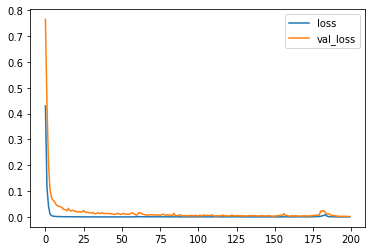

In [13]:
# plot the loss
plt.plot(r.history['loss'], label='loss')
plt.plot(r.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

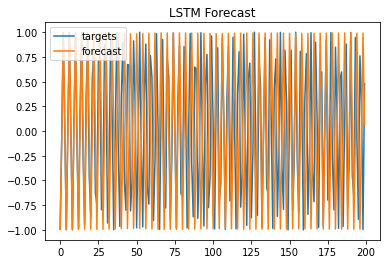

In [14]:
# Multi-step forecast
forecast = []
input = X[600]
while len(forecast) < len(Y[600:800]):
    # Reshape the input to N x T x D
    f = model.predict(input.reshape(1, T, 1))[0,0]
    forecast.append(f)

    # make a new input with the latest forecast
    input = np.roll(input, -1)
    input[-1] = f

plt.plot(Y[600:800], label='targets')
plt.plot(forecast, label='forecast')
plt.title("LSTM Forecast")
plt.legend()
plt.show()

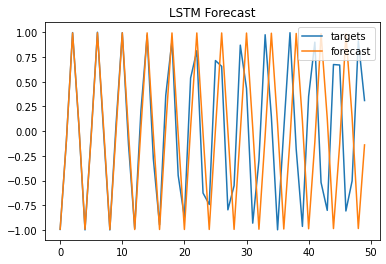

In [15]:
plt.plot(Y[600:650], label='targets')
plt.plot(forecast[:50], label='forecast')
plt.title("LSTM Forecast")
plt.legend()
plt.show()

We can see from the above plots that LSTM did get some prediction correct